In [51]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00


In [52]:
# =================================
# LIBRARIES
# =================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# =================================
# LOAD & PREVIEW DATA
# =================================

# Create a directory for the data
!mkdir -p data

# Download the dataset from data.transportation.gov
!wget -O data/raw_data.csv "https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD"
# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Set a style for the plots
sns.set(style="whitegrid")

# Load the Dataset
data_path = "data/raw_data.csv"
df_full = pd.read_csv(data_path)

# Display the first few rows of the dataframe
df_full.head()

#print(df.columns)


--2025-03-20 03:29:27--  https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD
Resolving data.transportation.gov (data.transportation.gov)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.transportation.gov (data.transportation.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/raw_data.csv’

data/raw_data.csv       [             <=>    ]  91.30M  5.09MB/s    in 17s     

2025-03-20 03:29:45 (5.36 MB/s) - ‘data/raw_data.csv’ saved [95738829]



,NTD ID,Agency,Primary UZA UACE Code,Rail/Bus/Ferry,Mode Name,Mode,TOS,Fixed Route Flag,Year,Event Description,...,Occupant of Other Vehicle Injuries,Occupant of Other Vehicle Serious Injuries,Other Injuries,Other Serious Injuries,Suicide Injuries,Suicide Serious Injuries,Trespasser Inuries (Subtotal),Trespasser Serious Injuries (Subtotal),Total Serious Injuries,Person List
0,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,Bus was parked in <REDACTED> <REDACTED> and an...,...,0,0,0,0,0,0,0,0,0,NaN
1,40035,Central Florida Regional Transportation Authority,65863,Bus,Demand Response,DR,DO,False,2024,Another vehicle made other front contact with ...,...,1,0,0,0,0,0,0,0,0,I Operator Inside Adult (19 to 60) F ; I ...
2,50027,Metro Transit,57628,Rail,Light Rail,LR,DO,True,2024,Officers responded to a shooting . Suspect was...,...,0,0,0,0,0,0,0,0,0,F Passenger Adult (19 to 60) M
3,90026,San Diego Metropolitan Transit System,78661,Rail,Light Rail,LR,DO,True,2024,San Diego Police took a female into custody af...,...,0,0,0,0,0,0,0,0,0,I Wait Leave Adult (19 to 60) M Y
4,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,operator was driving down <REDACTED> <REDACTED...,...,1,0,0,0,0,0,0,0,0,I Occ Other Veh Adult (19 to 60) M


In [20]:

# =================================
# CLEANING & FEATURE ENGINEERING
# =================================
#df['Year'] = df['Event Date'].dt.year
#df['Month'] = df['Event Date'].dt.month
#df['Weekday'] = df['Event Date'].dt.weekday

# Selected Columns
# Define the list of columns to keep
columns_to_keep = [
    'NTD ID',
    'Primary UZA UACE Code',
    'Rail/Bus/Ferry',
    'Mode Name',
    'Mode',
    'TOS',
    'Fixed Route Flag',
    'Year',
    'Event Date',
    'Event Time',
    'Event Type',
    'Event Type Group',
    'Collision With',
    'Property Damage',
    'Total Injuries',
    'Total Fatalities',
    'Towed (Y/N)',
    'Number of Transit Vehicles Involved',
    'Number of Non-Transit Vehicles Involved',
    'Number of Cars on Involved Transit Vehicles',
    'Non-Transit Vehicle Type List',
    'Location Type',
    'Latitude',
    'Longitude',
    'Weather',
    'Lighting',
    'Road Configuration',
    'Path Condition',
    'Right of Way Condition',
    'Intersection Control Device',
    'Transit Vehicle Action',
    'Other Transit Vehicle Action Description',
    'Non-Transit Vehicle Action List',
    'Transit (Y/N)',
    'Fuel Type',
    'Vehicle Speed',
    'Transit Vehicle Type',
    'Non-Transit Vehicle Type',
    'Transit Vehicle Manufacturer',
    'Total Serious Injuries'
]

df = df_full[columns_to_keep]
df.columns = df.columns.str.replace(' ', '')


In [21]:
eventtype = 'Non-Rail Collision'

df = df.query('EventType == @eventtype')


# Convert columns to datetime objects
df['EventDate'] = pd.to_datetime(df['EventDate'], format='%Y %B %d')
df['EventTime'] = pd.to_datetime(df['EventTime'].astype(str)).dt.time


# Extract features from Event Date
df['Month'] = df['EventDate'].dt.month
df['Day'] = df['EventDate'].dt.day
df['Weekday'] = df['EventDate'].dt.day_name()

# Create season feature (winter vs non-winter)
df['Season'] = df['Month'].apply(lambda m: 'winter' if m in [12, 1, 2] else 'non-winter')

# Convert Event Time to extract the hour (assuming it's in 24-hour format)
# Since 'Event Time' is already datetime.time, you can extract hour directly:
df['Hour'] = df['EventTime'].apply(lambda t: t.hour) #Using apply to access the hour attribute

# Categorize time of day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['TimeOfDay'] = df['Hour'].apply(categorize_time)

# Create rush hour flag
def is_rush_hour(hour):
    return 1 if (7 <= hour < 10 or 16 <= hour < 19) else 0

df['RushHour'] = df['Hour'].apply(is_rush_hour) #Removed extra =

# Select columns to display for checking
columns = ['EventDate', 'EventTime', 'Hour', 'TimeOfDay', 'RushHour', 'Season', 'Weekday', 'Day', 'Month']
print(df[columns].head())

# Store the new dataset to a new CSV file
#df = pd.read_csv('../data/feature_engineered_data.csv', index=False)

df['Towed(Y/N)'] = df['Towed(Y/N)'].map({'Y': 1, 'N': 0})

df.columns = df.columns.str.replace(' ', '')

    EventDate EventTime  Hour  TimeOfDay  RushHour      Season    Weekday  \
0  2024-11-30  08:46:00     8    morning         1  non-winter   Saturday   
1  2024-11-30  19:09:00    19    evening         0  non-winter   Saturday   
4  2024-11-27  15:20:00    15  afternoon         0  non-winter  Wednesday   
8  2024-11-25  07:38:00     7    morning         1  non-winter     Monday   
11 2024-11-23  18:08:00    18    evening         1  non-winter   Saturday   

    Day  Month  
0    30     11  
1    30     11  
4    27     11  
8    25     11  
11   23     11  


In [22]:
# count the number of missing values in each column
missing_values = df.isnull().sum()

# drop columns with more than 10% missing values
columns_to_drop = missing_values[missing_values > 0.1 * df.shape[0]].index
df = df.drop(columns=columns_to_drop)

# drop rows with missing values
df = df.dropna()

# drop duplicates
df = df.drop_duplicates()

# save the cleaned data, save to data folder as data_cleaned.csv
df.to_csv('data/cleaned_data.csv', index=False)

# print the number of rows and columns in the cleaned data
print(df.shape)

# print the number of missing values in the cleaned data
print(df.isnull().sum())

# print the number of duplicates in the cleaned data
print(df.duplicated().sum())

print(df.dtypes)

# print the first few rows of the cleaned data
print(df.head())

(62153, 41)
NTDID                                    0
PrimaryUZAUACECode                       0
Rail/Bus/Ferry                           0
ModeName                                 0
Mode                                     0
TOS                                      0
FixedRouteFlag                           0
Year                                     0
EventDate                                0
EventTime                                0
EventType                                0
EventTypeGroup                           0
CollisionWith                            0
PropertyDamage                           0
TotalInjuries                            0
TotalFatalities                          0
Towed(Y/N)                               0
NumberofTransitVehiclesInvolved          0
NumberofNon-TransitVehiclesInvolved      0
NumberofCarsonInvolvedTransitVehicles    0
LocationType                             0
Weather                                  0
Lighting                                 0

In [32]:
# =================================
# DEFINE TARGET VARIABLE
# =================================
df['MajorSafety'] = (
    (df['TotalFatalities'] > 0) |
    (df['TotalSeriousInjuries'] >0) |
    (df['TotalInjuries'] >0) |
    (df['PropertyDamage'] >25000)

).astype(int)

X = df.drop(columns=['MajorSafety', 'TotalFatalities','TotalSeriousInjuries','TotalInjuries', 'PropertyDamage', 'Hour'])
y = df['MajorSafety']

#f['Is_Severe'].value_counts()


In [53]:
# =================================
# PREPROCESSING PIPELINE
# =================================
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

#preprocessor = ColumnTransformer([
#    ('num', StandardScaler(), num_cols),
#    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
#])


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', TargetEncoder(handle_unknown='ignore'), cat_cols)  # Replace OHE with TargetEncoder
])

In [54]:
baseline_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier1= GradientBoostingClassifier()
classifier2= BaggingClassifier(DecisionTreeClassifier())
classifier3= ExtraTreesClassifier(n_estimators=100, random_state=42)
classifier10 = KNeighborsClassifier(n_neighbors=5)


In [55]:
Pipeline_Base = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', baseline_classifier)
])


Pipeline_1 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier1)
])

Pipeline_2 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier2)
])

Pipeline_3 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier3)
])

#BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
#KNeighborsClassifier()


In [56]:
# =================================
# MODEL TRAINING
# =================================
#pipeline = Pipeline([
#    ('preprocessing', preprocessor),
#    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
#])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
Pipeline_Base.fit(X_train, y_train)
y_pred = Pipeline_Base.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.51      0.55      2834
           1       0.86      0.90      0.88      9597

    accuracy                           0.81     12431
   macro avg       0.73      0.70      0.72     12431
weighted avg       0.80      0.81      0.80     12431

Confusion Matrix:
[[1447 1387]
 [ 973 8624]]
ROC-AUC Score: 0.7045999473929934


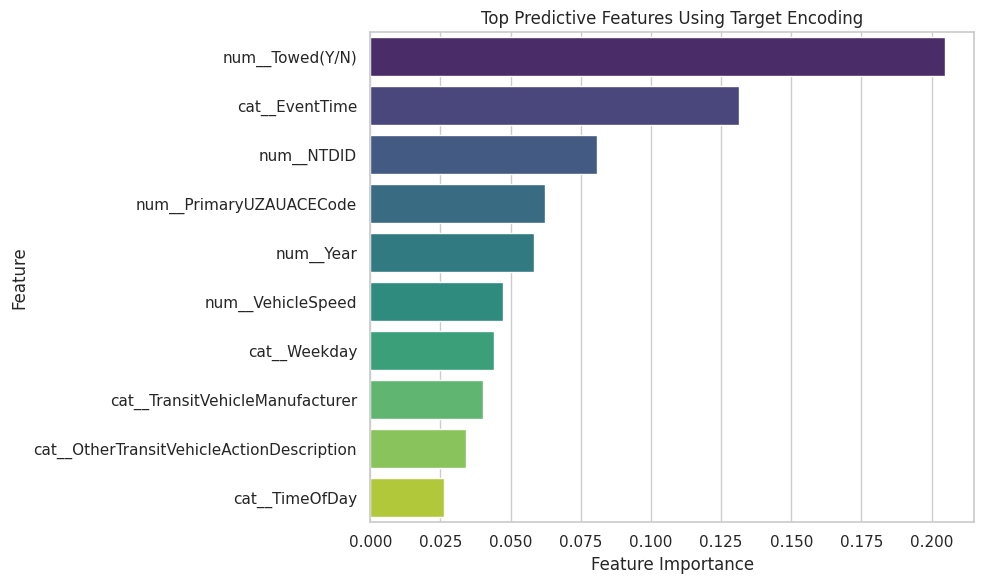

In [60]:
Pipeline_Base.fit(X_train, y_train)

# Access trained classifier
rf_model = Pipeline_Base.named_steps['classifier']

# Get feature names
all_feature_names = Pipeline_Base.named_steps['preprocessing'].get_feature_names_out()

# Get feature importances
importances = rf_model.feature_importances_

# Create DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictive Features Using Target Encoding")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Top 10 Predictive Features:
                                      Feature  Importance  \
3                             num__Towed(Y/N)    0.204898   
13                             cat__EventTime    0.131560   
0                                  num__NTDID    0.080748   
1                     num__PrimaryUZAUACECode    0.062395   
2                                   num__Year    0.058439   
7                           num__VehicleSpeed    0.047413   
29                               cat__Weekday    0.044104   
28            cat__TransitVehicleManufacturer    0.040159   
24  cat__OtherTransitVehicleActionDescription    0.034126   
31                             cat__TimeOfDay    0.026399   

                             Original Feature  
3                             num__Towed(Y/N)  
13                             cat__EventTime  
0                                  num__NTDID  
1                     num__PrimaryUZAUACECode  
2                                   num__Year  
7          

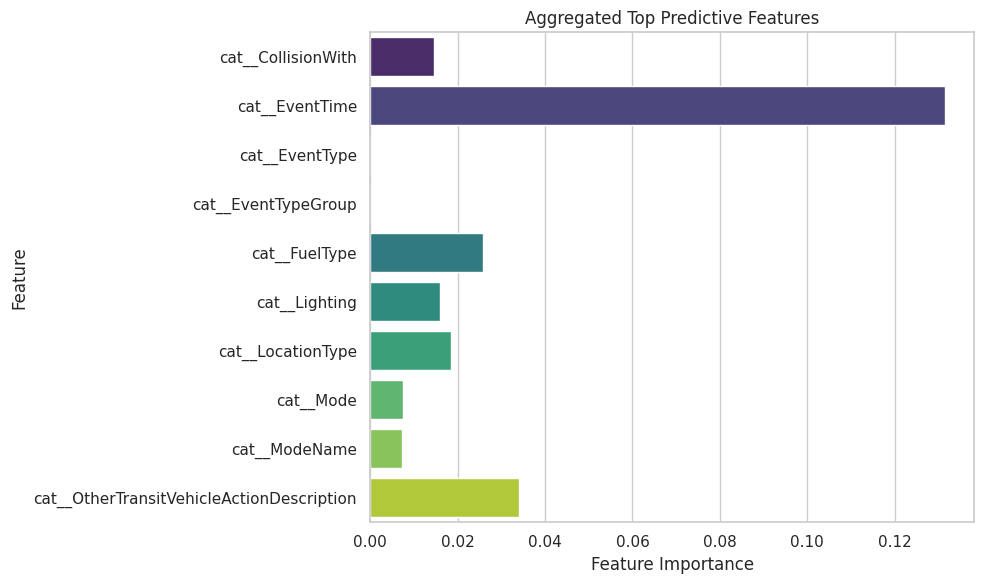

In [58]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_Base.named_steps['classifier']

# Get feature names
ohe = Pipeline_Base.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
#all_feature_names = list(num_cols) + list(encoded_cat_cols)
all_feature_names = Pipeline_Base.named_steps['preprocessing'].get_feature_names_out()

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Mapping only for categorical features
#original_feature_map = {encoded: original.split('_')[0] for encoded, original in zip(encoded_cat_cols, cat_cols)}
original_feature_map = {encoded: encoded.split('_')[0] for encoded in encoded_cat_cols}

# Aggregate importance by original feature
#feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
#    lambda x: original_feature_map[x] if x in original_feature_map else x
#)

feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
    lambda x: original_feature_map[x] if x in encoded_cat_cols else x
)

top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

aggregated_importance = feat_importance_df.groupby('Original Feature')['Importance'].sum().reset_index()
# Plot the aggregated feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Original Feature', data=aggregated_importance.head(top_n), palette='viridis')
plt.title("Aggregated Top Predictive Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Display top N features

#print(f"\nTop {top_n} Predictive Features:")
#print(feat_importance_df.head(top_n))

# Plot top features
#plt.figure(figsize=(10, 6))
#sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
#plt.title("Top Predictors of Major Safety Incidents")
#plt.xlabel("Feature Importance")
#plt.ylabel("Feature")
#plt.tight_layout()
#plt.show()


In [13]:
#Pipeline_1.fit(X_train, y_train)
y_pred = Pipeline_1.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.43      0.52      2834
           1       0.85      0.93      0.89      9597

    accuracy                           0.82     12431
   macro avg       0.75      0.68      0.70     12431
weighted avg       0.80      0.82      0.80     12431

Confusion Matrix:
[[1220 1614]
 [ 665 8932]]
ROC-AUC Score: 0.6805972285064088



Top 10 Predictive Features:
                                             Feature  Importance
7981                                    Towed(Y/N)_N    0.583457
7982                                    Towed(Y/N)_Y    0.221868
0                                              NTDID    0.068342
4                NumberofNon-TransitVehiclesInvolved    0.019112
1                                 PrimaryUZAUACECode    0.018327
8132    OtherTransitVehicleActionDescription_Head-On    0.013991
2                                               Year    0.008713
8183  OtherTransitVehicleActionDescription_Sideswipe    0.007408
6                                       VehicleSpeed    0.006396
7988              LocationType_Roadway: intersection    0.004943


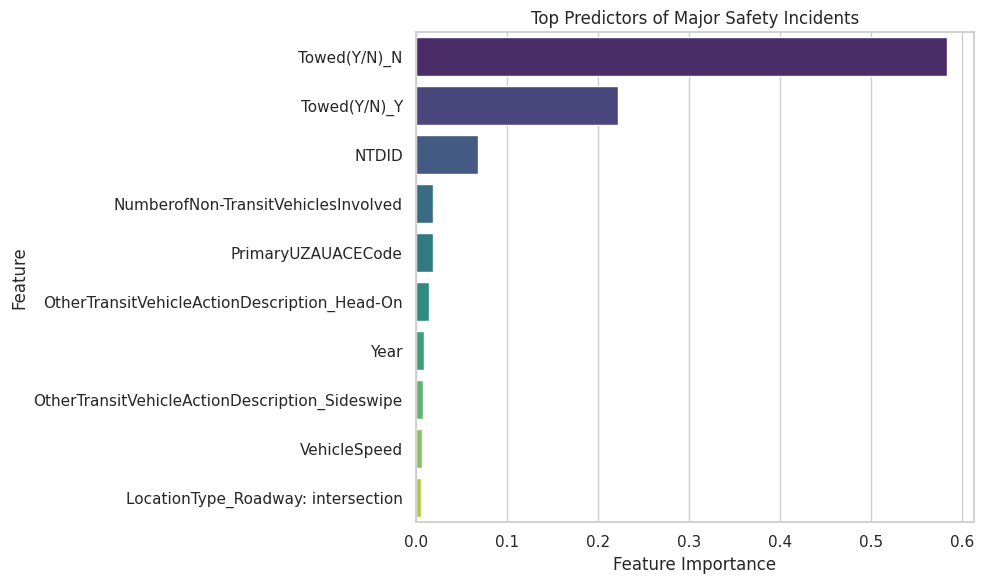

In [14]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_1.named_steps['classifier']

# Get feature names
ohe = Pipeline_1.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [15]:
Pipeline_2.fit(X_train, y_train)
y_pred = Pipeline_2.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61      2834
           1       0.89      0.87      0.88      9597

    accuracy                           0.82     12431
   macro avg       0.74      0.75      0.75     12431
weighted avg       0.82      0.82      0.82     12431

Confusion Matrix:
[[1782 1052]
 [1225 8372]]
ROC-AUC Score: 0.7505745848447553



Top 10 Predictive Features:
                                           Feature  Importance
7981                                  Towed(Y/N)_N    0.134420
7982                                  Towed(Y/N)_Y    0.133678
0                                            NTDID    0.067888
1                               PrimaryUZAUACECode    0.042015
7                                             Hour    0.033671
2                                             Year    0.032702
6                                     VehicleSpeed    0.032532
4              NumberofNon-TransitVehiclesInvolved    0.009499
8132  OtherTransitVehicleActionDescription_Head-On    0.006842
8539                             Weekday_Wednesday    0.006419


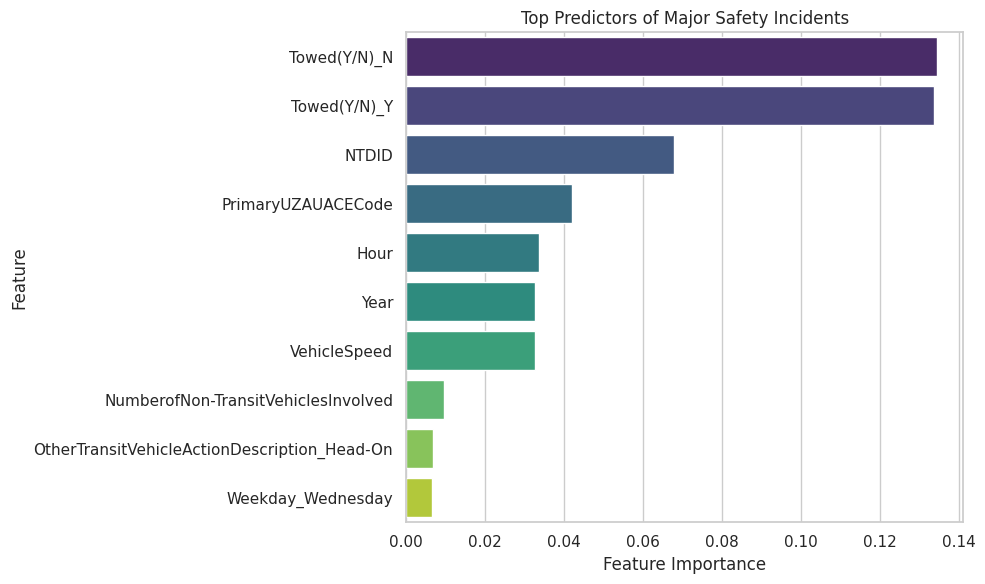

In [16]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_2.named_steps['classifier']

# Get feature names
ohe = Pipeline_2.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = np.mean([
            tree.feature_importances_ for tree in rf_model.estimators_
        ], axis=0)


feat_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)


# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [17]:
Pipeline_3.fit(X_train, y_train)

# Predict on Test Set
y_pred = Pipeline_3.predict(X_test)
y_probs = Pipeline_3.predict_proba(X_test)[:, 1]  # Probabilities for class 1


print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.30      0.40      2834
           1       0.82      0.94      0.88      9597

    accuracy                           0.80     12431
   macro avg       0.71      0.62      0.64     12431
weighted avg       0.77      0.80      0.77     12431

Confusion Matrix:
[[ 858 1976]
 [ 562 9035]]
ROC-AUC Score: 0.6220961634608675



Top 10 Predictive Features:
                 Feature  Importance
7981        Towed(Y/N)_N    0.093302
7982        Towed(Y/N)_Y    0.086035
0                  NTDID    0.030977
2                   Year    0.027744
1     PrimaryUZAUACECode    0.027144
7                   Hour    0.023986
6           VehicleSpeed    0.021664
8               RushHour    0.011347
8539   Weekday_Wednesday    0.009576
8538     Weekday_Tuesday    0.009544


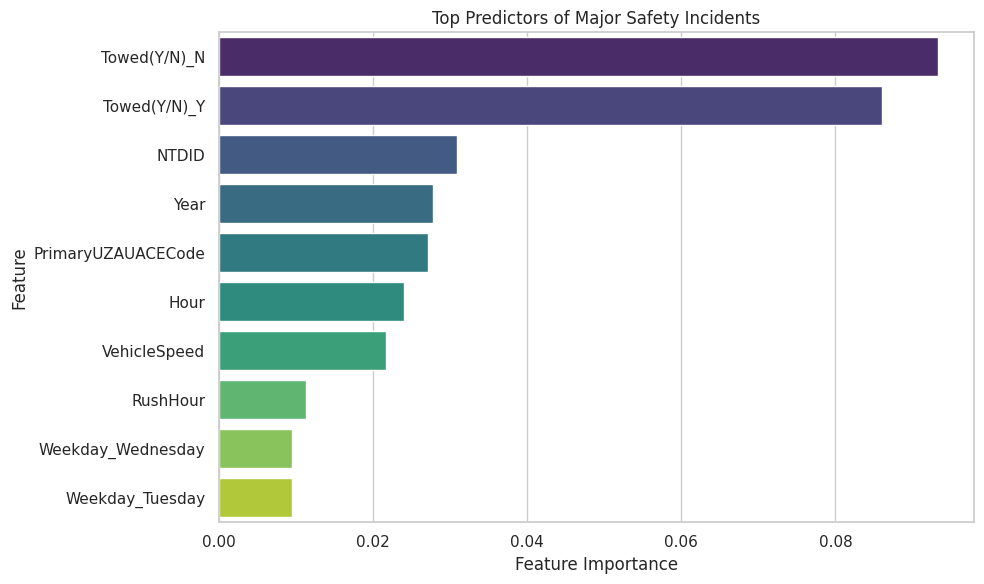

In [18]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_3.named_steps['classifier']

# Get feature names
ohe = Pipeline_3.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
Pipeline_10.fit(X_train, y_train)
# Compute Permutation Importance
KNNresult = permutation_importance(Pipeline_10, X_test, y_test, n_repeats=1, random_state=42, scoring='accuracy')

In [ ]:
y_pred = Pipeline_10.predict(X_test)  # Binary class labels
y_probs = Pipeline_10.predict_proba(X_test)[:, 1]  # Probabilities

# Print Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))  # Use probabilities instead of labels

In [ ]:

ohe = Pipeline_10.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': KNNresult.importances_mean
}).sort_values(by='Importance', ascending=False)


# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()